# Overall Planning for Mesa Debugging
- 1 [v] understanding the model, changing into infect goof + infect baad
- 2 [v] testing the code step by step and print stuff
- 3 [v] impliment the slider thing & test
- 4 [ ] make batch runner
- 5 [ ] make vis with Mesa
- 6 [ ] testing server and experiment making batch run server

## 1 - Completitive Linear Threshold Implimentation
impliment competitive linear threshold model proposed by He et al. [SIAM,2012](https://epubs.siam.org/doi/abs/10.1137/1.9781611972825.40)
The idea is: intead of imaginging information spread like disearse, imagine a network passing on +1s and -1s and hiiting designed threhold

In [33]:
## model
import math
import networkx as nx

from mesa import Agent, Model        ## This is the model - how agent interact 
from mesa.time import SimultaneousActivation      #This is the scheduler - how agents are activated
from mesa.datacollection import DataCollector     #This output a Pandas file
from mesa.space import NetworkGrid        #This means the model runs on  network (high dimentional space)


def number_state(model, state):
    return sum([a.state == state for a in model.grid.get_all_cell_contents()])

#this masures the spread of fake news (fake point +1)
def number_infected_fake(model):   
    return number_state(model, 1)

#this masures the spread of real news (fake point -1)
def number_infected_real(model):
    return number_state(model, -1)

def infected_list(model):
    return model.datacollector.get_model_vars_dataframe()


class InfoSpread(Model):
    """A virus model with some number of agents"""

    def __init__(self, num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold_fake = 2, threshold_real = -2):
        self.num_nodes = num_nodes
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k= avg_node_degree, p=rewire_prob)   #G generate graph structure
        self.grid = NetworkGrid(self.G) #grid is the Masa native defintion of space: a coorindate with specified topology on which agents sits and interact
        self.schedule = SimultaneousActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )

        self.datacollector = DataCollector(
            {
                "Infected_fake": number_infected_fake,
                "Infected_real": number_infected_real,
            }
        )

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = User(
                i,
                self,
                0,  #make the state a int
                threshold_fake,
                threshold_real
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes, initial infection bug free
        infected_nodes_fake = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        infected_nodes_real = self.random.sample(self.G.nodes(), self.initial_outbreak_size) 

        for a in self.grid.get_cell_list_contents(infected_nodes_fake):
            a.state = 1
            neighbors_nodes = self.grid.get_neighbors(a.pos)
            for n in self.grid.get_cell_list_contents(neighbors_nodes):
                n.state = 1
                
        for a in self.grid.get_cell_list_contents(infected_nodes_real):
            a.state = -1
            neighbors_nodes = self.grid.get_neighbors(a.pos)
            for n in self.grid.get_cell_list_contents(neighbors_nodes):
                n.state = -1  
                
        """
        state measures fake score!! the more negative the less likely to spread fake news
        also this model assumes that 
        1
        one piece of real news can cancel out one piece of fake news
        This model can be modulated by changing the value of fake and real
        
        2
        the inital braeakout size of fake and real news are the same
        This can be chaged by introducing a different initial breaksize for real and fake news
        however this score is kepet the same intentionally because too uch complexity is not good for modeling
        """        

        self.running = True
        self.datacollector.collect(self)

    def proportion_infected_fake(self):
        try:
            tot_fake = 0
            for i in self.grid.get_cell_list_contents(self.G):
                if i.state == 1:
                    tot_fake += 1
            return  tot_fake/ self.num_nodes
        except ZeroDivisionError:
            return math.inf
        
    def proportion_infected_real(self):
        try:
            tot_real = 0
            for i in self.grid.get_cell_list_contents(self.G):
                if i.state == -1:
                    tot_real += 1
            return  tot_real/ self.num_nodes
        except ZeroDivisionError:
            return math.inf

    def step(self):
        self.schedule.step()    #this model updates with symoutanous schedule, meaning, 
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        ''' could experiment terminating model here too'''
        for i in range(n):
            self.step()


class User(Agent):
    def __init__(self, unique_id, model, initial_state, threshold_fake, threshold_real):
        super().__init__(unique_id, model)   #super(). is to inherent agent's property. The user class is a subset of the agent class with additional properties. All the papermeter here are inherited from orginial agent class, everything is new and specific to the user class
        self.state = initial_state
        self.threshold_fake = threshold_fake
        self.threshold_real = threshold_real


    def get_infected_neighbor_count(self):
        '''Count how many of neighbors are infected'''
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        influence_count = 0
        for n in self.model.grid.get_cell_list_contents(neighbors_nodes):
            influence_count += n.state
        return (influence_count)
        

    def step(self):
        '''Calculates what the state should be in the next step'''
        # Start as the current state and modify below
        self._next_state = self.state
        count = self.get_infected_neighbor_count()
        if count >= self.threshold_fake:
            self._next_state = 1
        elif count <= self.threshold_real:
            self._next_state = -1
            
    def advance(self):
        self.state = self._next_state


## 2 - competive linear threshold vis and debug
Denug with visualization and print out
I'm pretty sure my model is no problem

In [130]:
model = InfoSpread(num_nodes=40, avg_node_degree=5, rewire_prob=.3, initial_outbreak_size=2, threshold_fake = 2, threshold_real = -2)


<ipython-input-33-b6d9fe57abe2>:70: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes_fake = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
<ipython-input-33-b6d9fe57abe2>:71: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes_real = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [131]:
model.run_model(5)

In [132]:
df = model.datacollector.get_model_vars_dataframe()
df

,Infected_fake,Infected_real
0,8,8
1,9,11
2,9,13
3,9,16
4,9,17
5,9,17


In [125]:
inf_count = []
state_color = []
for i in model.grid.get_cell_list_contents(model.G):
    inf_count.append(i.get_infected_neighbor_count())
    state = i.state
    if state == 1:
        state_color.append('#ED553B') # red
    elif state == -1:
        state_color.append('#3CAEA3') # green
    else:
        state_color.append('#F6D55C') #yellow       
        
inf_dic =  {}
for i in range(model.num_nodes):
    inf_dic.update({i:(str(i),inf_count[i])})

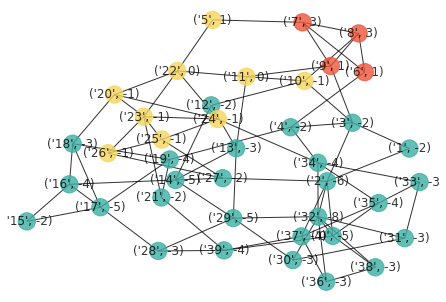

In [126]:
nx.draw_kamada_kawai(model.G, node_size=300,node_color=state_color, labels=inf_dic, alpha = 0.8)    

In [74]:
model.step()

In [46]:
model.proportion_infected_fake(),model.proportion_infected_real()

(0.05, 0.06)

## 3 - transmission scale Implimentation

In [138]:
## model
import math
import networkx as nx
import random as rd

from mesa import Agent, Model        ## This is the model - how agent interact 
from mesa.time import SimultaneousActivation      #This is the scheduler - how agents are activated
from mesa.datacollection import DataCollector     #This output a Pandas file
from mesa.space import NetworkGrid        #This means the model runs on  network (high dimentional space)


def number_state(model, state):
    return sum([a.state == state for a in model.grid.get_all_cell_contents()])

#this masures the spread of fake news (fake point +1)
def number_infected_fake(model):   
    return number_state(model, 1)

#this masures the spread of real news (fake point -1)
def number_infected_real(model):
    return number_state(model, -1)

def infected_list(model):
    return model.datacollector.get_model_vars_dataframe()


class InfoSpread(Model):
    """A virus model with some number of agents"""

    def __init__(self, num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold_fake = 2, threshold_real = -2, fake_p = 1, real_p=1):
        self.fake_p = fake_p
        self.real_p = real_p
        
        self.num_nodes = num_nodes
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k= avg_node_degree, p=rewire_prob)   #G generate graph structure
        self.grid = NetworkGrid(self.G) #grid is the Masa native defintion of space: a coorindate with specified topology on which agents sits and interact
        self.schedule = SimultaneousActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )

        self.datacollector = DataCollector(
            {
                "Infected_fake": number_infected_fake,
                "Infected_real": number_infected_real,
            }
        )

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = User(
                i,
                self,
                0,  #make the state a int
                threshold_fake,
                threshold_real
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes, initial infection bug free
        infected_nodes_fake = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        infected_nodes_real = self.random.sample(self.G.nodes(), self.initial_outbreak_size) 

        for a in self.grid.get_cell_list_contents(infected_nodes_fake):
            a.state = 1
            neighbors_nodes = self.grid.get_neighbors(a.pos)
            for n in self.grid.get_cell_list_contents(neighbors_nodes):
                n.state = 1
                
        for a in self.grid.get_cell_list_contents(infected_nodes_real):
            a.state = -1
            neighbors_nodes = self.grid.get_neighbors(a.pos)
            for n in self.grid.get_cell_list_contents(neighbors_nodes):
                n.state = -1  
                
        """
        state measures fake score!! the more negative the less likely to spread fake news
        also this model assumes that 
        1
        one piece of real news can cancel out one piece of fake news
        This model can be modulated by changing the value of fake and real
        
        2
        the inital braeakout size of fake and real news are the same
        This can be chaged by introducing a different initial breaksize for real and fake news
        however this score is kepet the same intentionally because too uch complexity is not good for modeling
        """        

        self.running = True
        self.datacollector.collect(self)

    def proportion_infected_fake(self):
        try:
            tot_fake = 0
            for i in self.grid.get_cell_list_contents(self.G):
                if i.state == 1:
                    tot_fake += 1
            return  tot_fake/ self.num_nodes
        except ZeroDivisionError:
            return math.inf
        
    def proportion_infected_real(self):
        try:
            tot_real = 0
            for i in self.grid.get_cell_list_contents(self.G):
                if i.state == -1:
                    tot_real += 1
            return  tot_real/ self.num_nodes
        except ZeroDivisionError:
            return math.inf

    def step(self):
        self.schedule.step()    #this model updates with symoutanous schedule, meaning, 
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        ''' could experiment terminating model here too'''
        for i in range(n):
            self.step()


class User(Agent):
    def __init__(self, unique_id, model, initial_state, threshold_fake, threshold_real):
        super().__init__(unique_id, model)   #super(). is to inherent agent's property. The user class is a subset of the agent class with additional properties. All the papermeter here are inherited from orginial agent class, everything is new and specific to the user class
        self.state = initial_state
        self.threshold_fake = threshold_fake
        self.threshold_real = threshold_real


    def get_infected_neighbor_count(self):
        '''Count how many of neighbors are infected'''
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        influence_count = 0
        for n in self.model.grid.get_cell_list_contents(neighbors_nodes):
            influence_count += n.state
        return (influence_count)
        

    def step(self):
        '''Calculates what the state should be in the next step'''
        fake_p = self.model.fake_p
        real_p = self.model.real_p
        
        # Start as the current state and modify below
        self._next_state = self.state
        count = self.get_infected_neighbor_count()
        if count >= self.threshold_fake:
            if rd.random() <= fake_p:   #example, p - 0.9 90%chance infect
                self._next_state = 1
        elif count <= self.threshold_real:
            if rd.random() <= real_p:
                self._next_state = -1
            
    def advance(self):
        self.state = self._next_state

### Testing

In [139]:
model = InfoSpread(num_nodes=40, avg_node_degree=5, rewire_prob=.3, initial_outbreak_size=2, threshold_fake = 2, threshold_real = -2, fake_p=0.8, real_p=0.5)


<ipython-input-138-abfe3f93dcda>:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes_fake = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
<ipython-input-138-abfe3f93dcda>:64: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes_real = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [140]:
model.run_model(5)

In [141]:
df = model.datacollector.get_model_vars_dataframe()
df

,Infected_fake,Infected_real
0,10,9
1,13,12
2,14,13
3,16,14
4,16,14
5,16,15


In [142]:
inf_count = []
state_color = []
for i in model.grid.get_cell_list_contents(model.G):
    inf_count.append(i.get_infected_neighbor_count())
    state = i.state
    if state == 1:
        state_color.append('#ED553B') # red
    elif state == -1:
        state_color.append('#3CAEA3') # green
    else:
        state_color.append('#F6D55C') #yellow       
        
inf_dic =  {}
for i in range(model.num_nodes):
    inf_dic.update({i:(str(i),inf_count[i])})

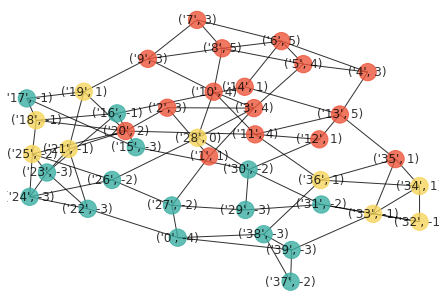

In [143]:
nx.draw_kamada_kawai(model.G, node_size=300,node_color=state_color, labels=inf_dic, alpha = 0.8)    

## 2 - Testing Batch Run
### 2.1 Batch run improvements
These are additional functions to process th PANDAS document
- calculating the infection time (measured in steps it takes)
- calculating the infection percentage

In [4]:
# Find the time it needed to infect the whole/part network
def find_last_increase (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(i+1)
    return(i+1)

def calculate_infection_time(df):
    time = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_time = find_last_increase(inf_data)
        time.append(infection_time)
    return(time)

In [5]:
#calculate percentage of infection
def find__final_infection_number (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(a[i+1])
    return(a[i+1])

def calculate_total_infection(df):
    total_inf = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_num = find__final_infection_number(inf_data)
        total_inf.append(infection_num)
    return(total_inf)

### 2.2 Testing Batch Run with different average neighbors

In [3]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
for i in range(100):
    model.step()

<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [4]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
total_inf = [-1, 0] #buffer item
total_inf.append(number_infected(model))
while( total_inf[len(total_inf)-1] != total_inf[len(total_inf)-2] ):
    model.step()
    total_inf.append(number_infected(model))

<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [5]:
df = model.datacollector.get_model_vars_dataframe()
df

,Infected,Susceptible
0,3,7
1,3,7


In [63]:
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"rewire_prob":0.15,
                "num_nodes": 80,
               "initial_outbreak_size" : 1,
                "threshold" : 2
                }
variable_params = {"avg_node_degree": range(2,20)
                  
                  }  #  {"rewire_prob": range(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

0it [00:00, ?it/s]<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
90it [00:01, 59.13it/s]


In [42]:
run_data = batch_run.get_model_vars_dataframe()

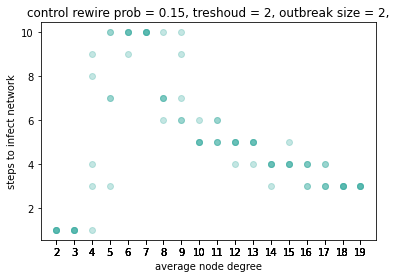

In [75]:
x = run_data['avg_node_degree'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("steps to infect network")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

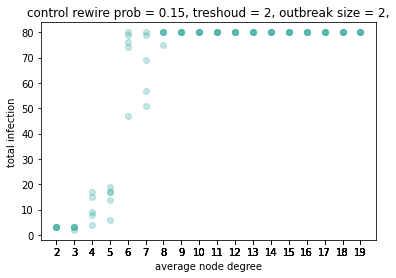

In [76]:
x = run_data['avg_node_degree'].values.tolist()
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("total infection")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

### 2.3 Testing batch run with changing rewireing factor

In [79]:
#batch running test 2
from mesa.batchrunner import BatchRunner

#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"num_nodes": 80,
               "avg_node_degree": 8,
               "initial_outbreak_size" : 1,
               "threshold" : 2}
variable_params = {"rewire_prob": rewire_list}  #  {"rewire_prob": drange(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

0it [00:00, ?it/s]<ipython-input-2-afaef7403751>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
105it [00:01, 61.51it/s]


In [80]:
run_data = batch_run.get_model_vars_dataframe()
#run_data

In [82]:
import matplotlib.pyplot as plt
import numpy

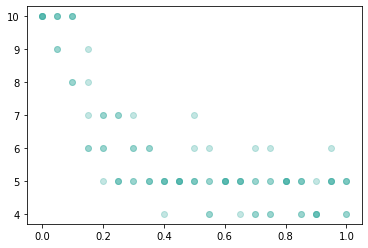

In [83]:

x = run_data['rewire_prob'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3',alpha = 0.3)

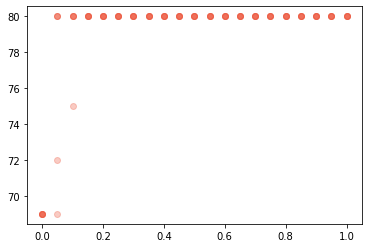

In [84]:
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#ED553B', alpha = 0.3)

## 4 & 5 Defining variables, design and experiment with server

### 5.1 Server

In [4]:
import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement
# from .model import InfoSpread, number_infected


def network_portrayal(G):
    # The model ensures there is always 1 agent per node

    def node_color(agent):
        if agent.state == "infected":
            return "#FF0000"
        elif agent.state == 'susceptible':
            return "#008000"

    def edge_color(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return "#000000"
        return "#e8e8e8"

    def edge_width(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return 3
        return 2

    def get_agents(source, target):
        return G.nodes[source]["agent"][0], G.nodes[target]["agent"][0]

    portrayal = dict()
    portrayal["nodes"] = [
        {
            "size": 6,
            "color": node_color(agents[0]),
            "tooltip": "id: {}<br>state: {}".format(
                agents[0].unique_id, agents[0].state
            ),
        }
        for (_, agents) in G.nodes.data("agent")
    ]

    portrayal["edges"] = [
        {
            "source": source,
            "target": target,
            "color": edge_color(*get_agents(source, target)),
            "width": edge_width(*get_agents(source, target)),
        }
        for (source, target) in G.edges
    ]

    return portrayal


network = NetworkModule(network_portrayal, 500, 500, library="d3")
chart = ChartModule(
    [
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ]
)


class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )


model_params = {
    "num_nodes": UserSettableParameter(
        "slider",
        "Number of agents",
        10,
        10,
        100,
        1,
        description="Choose how many agents to include in the model",
    ),
    
    "avg_node_degree": UserSettableParameter(
        "slider", "Avg Node Degree", 4, 2, 8, 2, description="Avg Node Degree"
    ),
    
    "rewire_prob": UserSettableParameter(
        "slider",
        "Rewire Probability",
        .1,
        0,
        1,
        .05,
        description = "Rewire probability"),
    
    "initial_outbreak_size": UserSettableParameter(
        "slider",
        "Initial Outbreak Size",
        1,
        1,
        5,
        1,
        description="Initial Outbreak Size",
    ),
    "threshold": UserSettableParameter(
        "slider",
        "Neighbor Threshold",
        2,
        1,
        5,
        1,
        description="Neighbor Threshold",
    )
}

server = ModularServer(
    InfoSpread, [network, MyTextElement(), chart], "Complex Contagion Model", model_params
)
server.port = 8521



<ipython-input-1-439a7ac5e84d>:55: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)


In [38]:
#testing visualizing charts in a server
from mesa.visualization.modules import ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from model import InfoSpread, number_infected
from mesa.visualization.modules import TextElement




In [39]:
class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )

In [43]:
chart = ChartModule([
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ])

server = ModularServer(InfoSpread,
                       [ MyTextElement(), chart],
                       "Complex Comtagion Batch Run")

In [ ]:
server.port = 8521 # The default
server.launch()

## 6 - Impliment one intervention


## Legacy code

In [ ]:
#define a better range function
def drange(x, y, jump):
  while x < y:
    yield round(float(x),2)
    x += jump